![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/tutorials/Certification_Trainings_JSL/5.1.Visual_Document_Classifier_v2.ipynb)

# Visual Document Classifier v2

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

### Colab Setup

In [1]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [2]:
from johnsnowlabs import nlp, visual, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

Please confirm authorization on : https://my.johnsnowlabs.com/oauth/authorize/?client_id=sI4MKSmLHOX2Pg7XhM3McJS2oyKG5PHcp0BlANEW&response_type=code&code_challenge_method=S256&code_challenge=MhI2eG3N0QM_BmsFheI3tlk2nFQxsdNu0PHD-YEBv7w&redirect_uri=http%3A%2F%2Flocalhost%3A38601%2Flogin


127.0.0.1 - - [17/Jan/2023 17:03:22] "GET /login?code=DVRYSRPlgtmCfvzqL3cl5ah3HJL19H HTTP/1.1" 200 -


Licenses extracted successfully
üìã Stored John Snow Labs License in /home/jose/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
üë∑ Setting up  John Snow Labs home in /home/jose/.johnsnowlabs, this might take a few minutes.
üôÜ JSL Home setup in /home/jose/.johnsnowlabs
üëå Everything is already installed, no changes made


In [3]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

In [4]:
from johnsnowlabs import nlp, visual, medical
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

üëå Launched cpu optimized session with with: üöÄSpark-NLP==4.2.4, üíäSpark-Healthcare==4.2.4, üï∂Spark-OCR==4.2.4, running on ‚ö° PySpark==3.1.2


## Load test images

In [5]:
import pkg_resources
test_image_path = visual.pkg_resources.resource_filename('sparkocr', 'resources/ocr/visualdoc/00556614_00556648.tif')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/jose/....|2023-01-16 18:40:...|375950|[49 49 2A 00 B8 B...|
+--------------------+--------------------+------+--------------------+



## Display images


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/visualdoc/00556614_00556648.tif
    Resolution: 72 dpi
    Width: 784 px
    Height: 1000 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


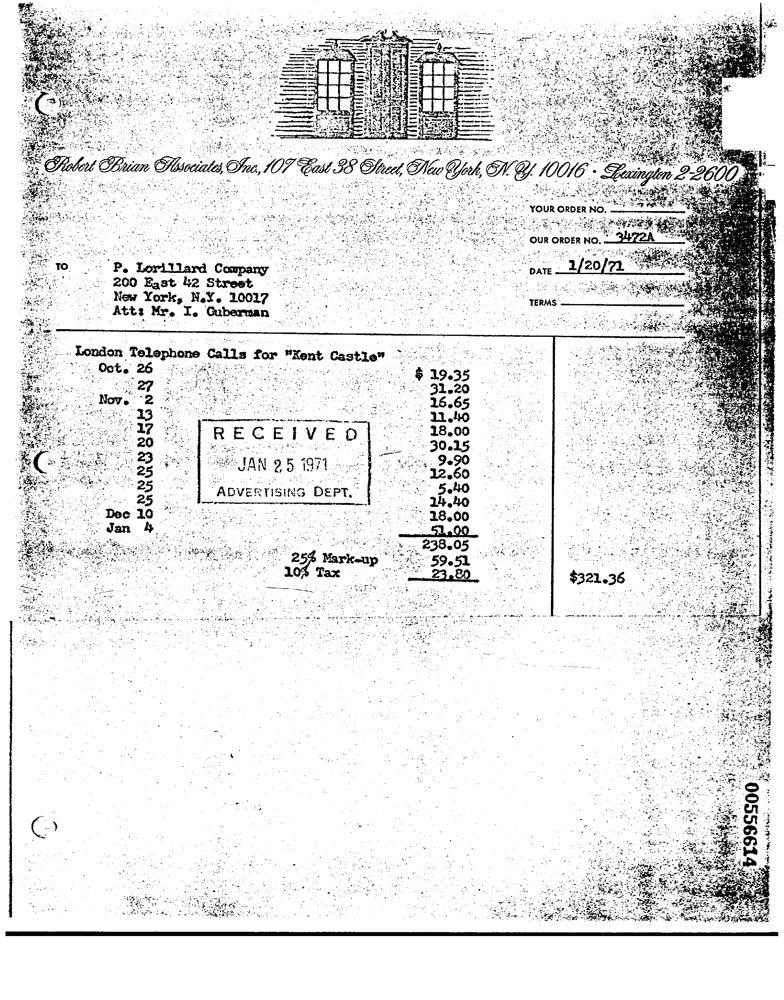

In [6]:
image_df = visual.BinaryToImage().transform(bin_df)
visual.display_images(image_df)

### Define pipeline

In [8]:
from sparkocr.utils import get_vocabulary_dict

binary_to_image = visual.BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR)

img_to_hocr = visual.ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = visual.HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_class = visual.VisualDocumentClassifierV2() \
    .pretrained("layoutlmv2_rvl_cdip_40k", "en", "clinical/ocr") \
    .setInputCols(["token", "image"]) \
    .setOutputCol("label")

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_class
])

## Call pipeline

In [9]:
results = pipeline.transform(bin_df).cache()

## Show results

In [10]:
results.select(["label"]) \
    .show(50, truncate=False)
            

+-------+
|label  |
+-------+
|invoice|
+-------+

